In [61]:
import multiprocessing
import time

SIZE = 8
first_row = (1 << (SIZE + 1)) - 1
last_row = first_row << (SIZE*(SIZE -1))
first_col = 0
for i in range(SIZE):
    first_col |= 1 << (SIZE * i)
last_col = first_col << (SIZE - 1)
# DO NOT CHANGE THE ORDER OF THE ITEMS!
DIRECTIONS = [(1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1), (0, 1)]
DIRECTIONS_OFFSETS = [SIZE + 1, SIZE, SIZE - 1, -1, -(SIZE + 1), -SIZE, -(SIZE - 1), 1]


def calculate_move(me: int, move: tuple[int, int], board: tuple[int, int]) -> tuple[int, int]:
    """
    `me` should be 0 or 1.
    """
    taken_places, colors = board

    row, col = move
    move_position_bit = 1 << (row * SIZE + col)

    colors_flip = 0

    for (d_row, d_col), bit_offset in zip(DIRECTIONS, DIRECTIONS_OFFSETS):
        row, col = move

        bit = move_position_bit
        flip_n = 0

        should_affect = False

        while True:
            row += d_row
            col += d_col

            if row >= SIZE or row < 0 or col >= SIZE or col < 0:
                break

            if bit_offset < 0:
                bit >>= -bit_offset
            else:
                bit <<= bit_offset

            if not (taken_places & bit):  # encountered empty place
                break

            if ((colors & bit) > 0) is (me > 0):  # a connection was made
                should_affect = True
                break

            flip_n |= bit

        if should_affect:
            colors_flip ^= flip_n

    if me:
        colors_flip |= move_position_bit  # flip the selected move position color

    return move_position_bit, colors_flip


def apply_move(board: tuple[int, int], move_flip: tuple[int, int]) -> tuple[int, int]:
    taken_places, colors = board
    position_flip, colors_flip = move_flip

    return taken_places ^ position_flip, colors ^ colors_flip


def translate_to_bin(board: list[list[int]]) -> tuple[int, int]:
    """
    2 values -> 1
    1 values -> 0
    | or , & and , ^ xor , ~ not , << shift left, >> shift right
    """
    taken_places, colors = 0, 0
    bit = 1

    for row in range(SIZE):
        for col in range(SIZE):
            value = board[row][col]
            if value != 0:
                taken_places |= bit

            if value == 2:
                colors |= bit

            bit <<= 1

    return taken_places, colors


def translate_bin_board_to_01none_lists(board: tuple[int, int]) -> list[list[int | None]]:
    taken_places, colors = board

    rows = []
    bit = 1
    for i in range(SIZE):
        row = []
        for j in range(SIZE):
            is_taken_place = taken_places & bit

            if is_taken_place:
                color = (colors & bit) > 0
                row.append(color)
            else:
                row.append(None)
            bit <<= 1

        rows.append(row)
    return rows


def translate_bin_move_to_row_col(bin_move):
    move_position_bit, _ = bin_move
    position_in_board = 0
    while move_position_bit:
        position_in_board += 1
        move_position_bit >>= 1
    position_in_board -= 1

    row, col = divmod(position_in_board, SIZE)
    return row, col


def count_binary_1s(n: int) -> int:
    c = 0
    while n != 0:
        if n & 1:
            c += 1
        n >>= 1
    return c


def preview_board(board: tuple[int, int]):
    taken_places, colors = board

    bit = 1
    board_repr = ""
    for i in range(SIZE):
        for j in range(SIZE):
            is_place_taken = taken_places & bit
            if not is_place_taken:
                board_repr += "."
            else:
                board_repr += "1" if colors & bit else "0"
            bit <<= 1
        board_repr += "\n"
    return board_repr


STARTING_BOARD = [[0] * SIZE for _ in range(SIZE)]
STARTING_BOARD[SIZE // 2 - 1][SIZE // 2 - 1] = 1
STARTING_BOARD[SIZE // 2][SIZE // 2] = 1
STARTING_BOARD[SIZE // 2 - 1][SIZE // 2] = 2
STARTING_BOARD[SIZE // 2][SIZE // 2 - 1] = 2

STARTING_BIN_BOARD = translate_to_bin(STARTING_BOARD)


########################################################################################################################


def get_available_moves(me, board):
    moves = []

    taken_places, colors = board

    bit = 1
    for row in range(SIZE):
        for col in range(SIZE):
            if not taken_places & bit:  # I.E. place is not taken
                move = (row, col)
                bin_move = calculate_move(me, move, board)
                position_bit, colors_flip = bin_move
                if (colors_flip & (~position_bit)) != 0:  # equivalent to "is valid move?"
                    moves.append(bin_move)

            bit <<= 1
    return moves


def order_moves(moves, start_with_move):
    moves_with_values = []
    for move in moves:
        if move == start_with_move:
            value = float('inf')

        else:
            location, color_flip = move
            pieces_flipped = count_binary_1s(color_flip)
            if location & color_flip == location:
                pieces_flipped -= 1
            value = -pieces_flipped

            row, col = translate_bin_move_to_row_col(move)
            if row == 0 or row == SIZE - 1:
                value += 7
            if col == 0 or col == SIZE - 1:
                value += 7

        moves_with_values.append([value, move])

    ordered_moves = sorted(moves_with_values, key=lambda x: x[0])
    return [x[1] for x in ordered_moves]


def rotate_masking(masking: list[list]):
    result = []
    for row in masking:
        result.append(row + row[::-1])

    n = len(result)
    for i in range(n):
        result.append(result[n - i - 1])
    return result


MASKING = [
    [30000, -15, 25, 5],
    [-15, -75, 2, 2],
    [25, 2, 15, 2],
    [5, 2, 2, 3]
]


MASKING = rotate_masking(MASKING)


def evaluate_board(board, move):
    bit = 1
    taken_places, colors = board
    first_player_taken_places, second_player_taken_places = 0, 0

    value = 0
    for row in range(SIZE):
        for col in range(SIZE):
            if taken_places & bit:
                masking_value = MASKING[row][col]
                if colors & bit:
                    value += masking_value
                    first_player_taken_places += 1
                else:
                    value -= masking_value
                    second_player_taken_places += 1

            bit <<= 1
    
    number_of_taken_places = first_player_taken_places + second_player_taken_places
    # location, color_flip = move
    # pieces_flipped = count_binary_1s(color_flip)
    # if location & color_flip == location:
    #     pieces_flipped -= 1


    if number_of_taken_places >= 55:
        value += 30 * (first_player_taken_places - second_player_taken_places)
    else:
        value -= 0.1 * (64 - number_of_taken_places) * (first_player_taken_places - second_player_taken_places)
        # value -= 10 * (first_player_taken_places - second_player_taken_places)
        
    if first_player_taken_places == 0:
        return float('-inf')
    elif second_player_taken_places == 0:
        return float('inf')

    first_player_options_number = len(get_available_moves(1, board))
    second_player_options_number = len(get_available_moves(0, board))
    value += number_of_taken_places / 4 * (first_player_options_number - second_player_options_number)

    taken_0_places = taken_places ^ colors
    player_row_col = 0
    first_row1 = colors & first_row
    last_row1 = colors & last_row
    first_col1 = colors & first_col
    last_col1 = colors & last_col

    first_row0 = taken_0_places & first_row
    last_row0 = taken_0_places & last_row
    first_col0 = taken_0_places & first_col
    last_col0 = taken_0_places & last_col
    x = 20
    if first_row1 and not first_row0:
        player_row_col += x
    if first_row0 and not first_row1:
        player_row_col -= x


    if last_row1 and not last_row0:
        player_row_col += x
    if last_row0 and not last_row1:
        player_row_col -= x


    if first_col1 and not first_col0:
        player_row_col += x
    if first_col0 and not first_col1:
        player_row_col -= x 


    if last_col1 and not last_col0:
        player_row_col += x
    if last_col0 and not last_col1:
        player_row_col -= x  
    value += player_row_col

    # y = 15 
    # if first_col0 > first_col1:
    #     value -= y
    # if first_col0 < first_col1:
    #     value += y

    # if first_row0 > first_row1:
    #     value -= y
    # if first_row0 < first_row1:
    #     value += y

    # if last_col0 > last_col1:
    #     value -= y
    # if last_col0 < last_col1:
    #     value += y

    # if last_row0 > last_row1:
    #     value -= y
    # if last_row0 < last_row1:
    #     value += y


    lists_board = translate_bin_board_to_01none_lists(board) ######  sandwich
    strips = []
    for i in range(SIZE):
        row_strip = []
        col_strip = []
        for j in range(SIZE):
            row_strip.append(lists_board[i][j])
            col_strip.append(lists_board[j][i])
        # maybe check if the strip is full
        strips.append(row_strip)
        strips.append(col_strip)

    for i in range(3, SIZE):
        left_diagonal_strip = []  # like /
        right_diagonal_strip = []  # like \
        for j in range(i + 1):
            left_diagonal_strip.append(lists_board[j][i - j])
            right_diagonal_strip.append(lists_board[j][(SIZE - i - 1) + j])
        # maybe check if the strip is full
        strips.append(left_diagonal_strip)
        strips.append(right_diagonal_strip)

    for strip in strips:
        sandwich_bread = None
        sandwich_content = None
        bread_start_index = 0
        content_start_index = 0
        should_add_bread_end = False

        for i in range(len(strip)):
            color = strip[i]

            if color is None:
                if should_add_bread_end and i != len(strip) - 1:
                    bread_end_size = i - content_start_index
                    value += 2 * bread_end_size * (1 if sandwich_bread else -1)
                    should_add_bread_end = False
                sandwich_bread = None
                sandwich_content = None
                continue

            if sandwich_bread is None:
                sandwich_bread = color
                bread_start_index = i

            else:
                if color != sandwich_bread:
                    if sandwich_content is None:
                        sandwich_content = color
                        content_start_index = i

                elif sandwich_content is not None:  # a sandwich is ready
                    if should_add_bread_end and i != len(strip) - 1:
                        bread_end_size = i - content_start_index
                    ####    value += 2 * bread_end_size * (1 if sandwich_bread else -1)
                        should_add_bread_end = False
                        
                    # score sandwich: TODO
                    start_bread_size = content_start_index - bread_start_index
                    content_size = i - content_start_index
                    base_score = max(start_bread_size * 2 - content_size, 3)
                    # if bread_start_index == 0 or i == SIZE - 1: 
                    # else:
                   ### value += base_score * (1 if sandwich_content else -1)

                    should_add_bread_end = True

                        

                    sandwich_bread = sandwich_content
                    bread_start_index = content_start_index
                    content_start_index = i
            should_add_bread_end = False

    return value


########################################################################################################################

best_move_of_last_search = None


def minimax(board, depth, maximizing_player: bool, distance_from_root=0, alpha=-float('inf'), beta=float('inf'), last_played_move = None,
            had_moves_last_turn=True, update_current_best_move_dict=None):

    available_moves = get_available_moves(1 if maximizing_player else 0, board)
    if distance_from_root == 0:
        available_moves = order_moves(available_moves, best_move_of_last_search)
    else:
        available_moves = order_moves(available_moves, None)

    if len(available_moves) == 0:
        if not had_moves_last_turn:
            return None, evaluate_board(board, last_played_move)
        return minimax(board, depth, not maximizing_player, distance_from_root + 1, alpha, beta, last_played_move, False)

    if maximizing_player:
        best_value = -float('inf')
        best_move = None

        for move in available_moves:
            board = apply_move(board, move)
            if depth == 1:
                child_value = evaluate_board(board, move)
            else:
                _, child_value, = minimax(board, depth - 1, False, distance_from_root + 1, alpha, beta, last_played_move)

            board = apply_move(board, move)  # reverse board to previous state

            if child_value > best_value:
                best_value = child_value
                best_move = move
                if distance_from_root == 0 and update_current_best_move_dict is not None:
                    update_current_best_move_dict[0] = move

            alpha = max(alpha, best_value)
            if beta <= alpha:
                break

    else:
        best_value = float('inf')
        best_move = None
        for move in available_moves:
            board = apply_move(board, move)
            if depth == 1:
                child_value = evaluate_board(board, move)
            else:
                _, child_value = minimax(board, depth - 1, True, distance_from_root + 1, alpha, beta, last_played_move)
            board = apply_move(board, move)  # reverse board to previous state

            if child_value < best_value:
                best_value = child_value
                best_move = move
                if distance_from_root == 0 and update_current_best_move_dict is not None:
                    update_current_best_move_dict[0] = move

            beta = min(beta, best_value)
            if beta <= alpha:
                break

    return best_move, best_value


def iterative_deepening_minimax(board, me, max_time, return_dict):
    start_time = time.time()

    global best_move_of_last_search

    depth = 1
    while True:
        best_move, _ = minimax(board, depth, me, update_current_best_move_dict=return_dict)

        if time.time() - start_time < max_time:
            best_move_of_last_search = best_move
            return_dict[1] = best_move
        else:
            break

        depth += 2


########################################################################################################################
def get_move(me: int, board: list[list[int]]) -> tuple[int, int]:
    bin_board = translate_to_bin(board)
    me = me - 1

    # Set the maximum time limit for minimax
    max_time = 0.48  # when 0.5 seconds reached, we loose automatically

    # Initialize a return dictionary to collect the best move
    return_dict = multiprocessing.Manager().dict()

    # Create a process to run minimax with a time limit
    process = multiprocessing.Process(target=iterative_deepening_minimax, args=(bin_board, me, max_time, return_dict))
    process.start()
    process.join(timeout=max_time)

    # If the process is still running, terminate it
    if process.is_alive():
        process.terminate()
        process.join()

    best_move = return_dict[0]  # 0 for middle search best move, 1 for last search best move
    # TODO if using return_dict[1], you can delete the dictionary parameter in the minimax function.
    return translate_bin_move_to_row_col(best_move)


# Nice function for playing against ourselves
# Sandwich maybe with bits
# Add evaluation for stable disks that cannot be flipped
# When there is stable for example a corner or an e
# Density function


def main(*_):
    # t1 = time.perf_counter()
    # minimax(STARTING_BIN_BOARD, 9, True)
    # t2 = time.perf_counter()
    # print(t2 - t1)

    return_dict = multiprocessing.Manager().dict()
    process = multiprocessing.Process(target=iterative_deepening_minimax,
                                      args=(STARTING_BIN_BOARD, 1, 10, return_dict))

    process.start()
    process.join(timeout=10)
    if process.is_alive():
        process.terminate()
        process.join()
    # iterative_deepening_minimax(STARTING_BIN_BOARD, 0.5, 1, return_dict)

    print(return_dict.get(0))


if __name__ == '__main__':
    main()
    # get_move(1, STARTING_BOARD)
    
# Why for this code as black against stable it gives him the corner even when corner value is really high but not when its zero?
# Does is mask correctly for the other player?
# Something is weird

None


In [68]:
evaluate_board((2**64, 2**64), 1)

0

In [27]:
evaluate_board(bin(2**64)-3, bin(2**64)-10) 1)

SyntaxError: unmatched ')' (2116756430.py, line 1)

In [ ]:
translate_to_bin([1] )

In [36]:
a = [[1] * 8] * 8
a[0][0] = 0
a

[[0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1]]

In [58]:
len(bin(2**64-3))

66

In [62]:
evaluate_board((2**64 - 1, 2**64 - 1), 1)

119940

In [18]:
translate_to_bin()

'0b1100000011000000000000000000000000000'

In [15]:
translate_to_bin(STARTING_BIN_BOARD)

TypeError: 'int' object is not subscriptable

In [48]:
a, b = bin(2**65 - 4), bin(2**65 - 3)
print(int(a,2), int(b,2))

36893488147419103228 36893488147419103229


In [52]:
a, b = 2**65 - 4, 2**65 - 3
print(bin(a&b))

0b11111111111111111111111111111111111111111111111111111111111111100


In [ ]:
if _name_ == '_main_':
    main()
    
# Nice function for playing against ourselves
# Add evaluation for stable disks that cannot be flipped
# When there is stable for example a corner or an e
# Density function
# Add an array of tracking times for each part of the code

In [103]:
def reversi_to_chess_board(reversi_board):
    chess_board = chess.Board(fen='8/8/8/8/8/8/8/8')
    for i in range(len(reversi_board)):
        for j in range(len(reversi_board[i])):
            if reversi_board[i][j] == 1:
                chess_board.set_piece_at(i * 8 + j, chess.Piece(chess.PAWN, 0))
            elif reversi_board[i][j] == 2:
                chess_board.set_piece_at(i * 8 + j, chess.Piece(chess.PAWN, 1))

    return chess_board

In [143]:
def square_to_move(square):
    return (ord(square[0].lower()) -97, int(square[1]) - 1)

In [147]:
def bot_move(board, me, depth):
    best_move, best_value = get_move(me, board)
    position_bit, colors_flip = calculate_move(me, move, board)
    board = apply_move(board, (position_bit, colors_flip))
    return board, best_move, best_value

def human_move(board, me):
    move = input()
    move = square_to_move(move)
    position_bit, colors_flip = calculate_move(me, move, translate_to_bin(board))
    if (colors_flip & (~position_bit)) != 0:  # equivalent to "is valid move?"
        apply_move(board, (position_bit, colors_flip))
        return board
    else:
        print('Illegal move')
        print()
        return human_move(board, me)

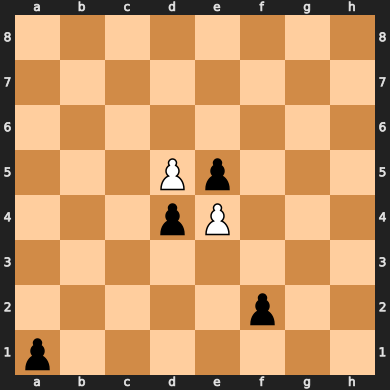

Black's turn


 d6


Illegal move



 d6


Illegal move



KeyboardInterrupt: Interrupted by user

In [150]:
board = STARTING_BOARD

turn = 1
for i in range(SIZE ** 2):
    if turn == 1:
        display(reversi_to_chess_board(board))
        print("Black's turn" if turn == 1 else "White's turn")
        board = human_move(board, turn)
        
    else:
        board, best_move, best_value = bot_move(me, board)
        
    available_moves = get_available_moves(turn, board)
    if not len(available_moves) == 0:
        turn = 1 - turn
    else:
        print('No moves')
    print(best_move, best_value)        
        

In [148]:
move = square_to_move('a1')
print(move)
calculate_move(1, move, translate_to_bin(board))

(0, 0)


(1, 1)

In [ ]:
def play()

In [48]:
preview_board(bin_board)

'01......\n........\n........\n...01...\n...10...\n........\n........\n........\n'

In [78]:
print(preview_board(STARTING_BIN_BOARD))

........
........
........
...01...
...10...
........
........
........



In [65]:
minimax(bin_board, 1, 1)

3 4
3 4
3 4
3 4


((524288, 134742016), -56.9)

In [64]:
bin_board = apply_move(STARTING_BIN_BOARD, (3, 2))

In [75]:
print(preview_board(apply_move(STARTING_BIN_BOARD, (3, 4))))

00......
........
........
...01...
...10...
........
........
........



In [34]:
binary_string = '0b1100000011000000010000000000000000000'

# Convert the binary string to a list of lists (8x8 matrix)
matrix = [[int(bit) for bit in binary_string[2 + i * 8:2 + (i + 1) * 8]] for i in range(8)]

# Print the visual representation of the matrix
for row in matrix:
    print(' '.join(map(str, row)))


1 1 0 0 0 0 0 0
1 1 0 0 0 0 0 0
0 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0
0 0 0 0 0





In [ ]:
def density(board, me):

    taken_places, colors = board

    row, col = move
    move_position_bit = 1 << (row * SIZE + col)

    colors_flip = 0

    for (d_row, d_col), bit_offset in zip(DIRECTIONS, DIRECTIONS_OFFSETS):
        row, col = move

        bit = move_position_bit
        flip_n = 0

In [ ]:
def density(board, me):
    density = 0
    for i in binary_string:
        if me == 1:
            

In [81]:
def calculate_density(board, your_color):
    board_size = 8  # Adjust this to match your chess board size
    your_density = 0
    opponent_density = 0

    for row in range(board_size):
        for col in range(board_size):
            if board[row][col] == your_color:
                neighbors = [(row - 1, col - 1), (row - 1, col), (row - 1, col + 1),
                             (row, col - 1), (row, col + 1),
                             (row + 1, col - 1), (row + 1, col), (row + 1, col + 1)]

                for neighbor_row, neighbor_col in neighbors:
                    if 0 <= neighbor_row < board_size and 0 <= neighbor_col < board_size:
                        if board[neighbor_row][neighbor_col] == your_color:
                            your_density += 1
                        else:
                            opponent_density += 1

    total_your_pieces = sum(row.count(your_color) for row in board)
    total_opponent_pieces = sum(row.count(1 - your_color) for row in board)

    your_density /= total_your_pieces
    opponent_density /= total_opponent_pieces

    return your_density, opponent_density

In [87]:
# Usage example:
your_color = 1  # Replace with your color value (1 or 0)
board = [[0, 1, 1, 0, 0, 0, 1, 0],
         [1, 1, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 1, 1, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]]

density = calculate_density(translate_to_bin(board)[0], your_color)
print("Your density:", density)

ZeroDivisionError: division by zero

In [86]:
translate_to_bin(board)

(39583928558406, 0)

In [85]:
def calculate_density(taken_places, colors):
    board_size = 8  # Adjust this to match your chess board size
    your_color = 1  # Change to match your color (1 or 0)

    your_density = 0
    opponent_density = 0

    for row in range(board_size):
        for col in range(board_size):
            bit_position = row * board_size + col

            if (taken_places & (1 << bit_position)) != 0:
                if (colors & (1 << bit_position)) == your_color:
                    your_density += 1
                else:
                    opponent_density += 1

    total_your_pieces = bin(taken_places & colors).count('1')
    total_opponent_pieces = bin(taken_places & ~colors).count('1')

    your_density /= total_your_pieces
    opponent_density /= total_opponent_pieces

    return your_density, opponent_density


In [ ]:
taken_places 1
colors 0

In [ ]:
# Nice function for playing against ourself
# Sandwich maybe with bits
# Add evaluation for stable disks that cannot be flipped
# When there is stable for example a corner or an e